# CBOW word2vec with TF Text

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). The rest of this notebook demonstrates how to implement the CBOW model with TensorFlow Text leveraging a publically available dataset. The steps are as follows

* Using TF Text to build a vocabulary
* Using TF Text to build a CBOW data (context, target) generator
* Using TF Keras to build the CBOW model architecture
* Using TF Keras to train the CBOW model and get Word Embeddings
* Using Sklearn euclidean distances to calculate distance among words and get the k-nearst ones

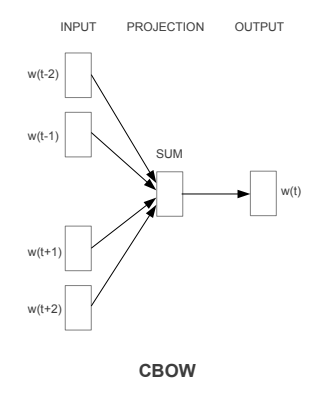

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
%%capture
%%bash
pip install -q tensorflow_text
pip install wandb -q

In [0]:
import wandb

import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as tftext

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.utils import plot_model

import nltk
from nltk.corpus import gutenberg
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
wandb.init(entity = "dzlab", project = "tf-text-cbow")

W&B Run: https://app.wandb.ai/dzlab/tf-text-cbow/runs/o0vt2tu9

In [0]:
config = wandb.config
config.bs = 64
config.window = 2
config.shuffle_buffer_size = 1000
config.seed = 31
config.embed_size = 100

## Data

In [8]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.corpus.gutenberg.fileids()

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [0]:
corpus = gutenberg.sents('bible-kjv.txt')

Combine the text into on giant sentence, this is just to avoid uncessary padding as sentences in this text have different lengths.

In [0]:
norm_corpus = list(map(lambda s: ' '.join(s), corpus))
norm_corpus = [' \n '.join(norm_corpus)]
norm_corpus = [re.sub("\d+|:", "", sentence) for sentence in norm_corpus]

### Text preprocessing

#### Vocabulary creation

A first step of the text processing is to build a vocabulary out of the corpus. We will extract unique words and build a lookup table to map them into a unique numeric identifier.

In [0]:
def tokenize(text):
  # Lower case and normalize text
  text = tftext.case_fold_utf8(text)
  text = tftext.normalize_utf8(text, "NFD")
  # Tokenize and encode the text
  tokens_rt = tokenizer.tokenize(text)
  return tokens_rt

def create_vocab(text):
  # Create vocabulary from text
  rt = tokenize(text)
  tokens = rt.to_list()[0]
  return list(set(tokens))

def create_word2index(vocab, num_oov = 1):
  # Create a lookup table for a vocabulary
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab, values=vocab_values, key_dtype=tf.string, value_dtype=tf.int64)
  return tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)

def create_index2word(vocab):
  # Create a lookup table for a index to token
  vocab_values = tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64)
  init = tf.lookup.KeyValueTensorInitializer(keys=vocab_values, values=vocab)
  return tf.lookup.StaticHashTable(initializer=init, default_value=tf.constant('unk'), name="index2word")

In [12]:
tokenizer = tftext.UnicodeScriptTokenizer()
vocab = create_vocab(['PAD' + ' '.join(norm_corpus)])
word2index = create_word2index(vocab)
index2word = create_index2word(vocab)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [0]:
vocab_size = len(vocab)

#### CBOW data generation

To generate data for training the CBOW model, we need a sliding window of size `2 * side_size + 1`. At each step, we slide the window to the right and generate a training sample that consists of: 
* A target word which is located in the centre of the window
* The concatenation of the sequence of word of size `side_size` on each size.

In [0]:
@tf.function
def basic_preprocess(text):
  # Tokenize text and create CBOW features/labels
  tokens_rt = tokenize(text)
  # Create ngrams of size 2*window+1
  ngrams = tftext.ngrams(tokens_rt, width=(2*config.window+1), reduction_type=tftext.Reduction.STRING_JOIN, string_separator=' ')
  # Extract Context and Target
  ngrams = tokenizer.tokenize(ngrams)
  ngrams = ngrams.to_tensor()
  ngrams = tf.squeeze(ngrams, axis=0)
  context = tf.concat(values=[ngrams[:, :2], ngrams[:, -2:]], axis=-1)
  target = ngrams[:, 2]
  # Encode tokens
  features = tf.ragged.map_flat_values(word2index.lookup, context)
  labels = tf.ragged.map_flat_values(word2index.lookup, target)
  return features, labels

In [0]:
text = ["PAD "*config.window + sentence + " PAD"*config.window for sentence in norm_corpus]
train_data = basic_preprocess(text)

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(train_data)
train_ds = train_ds.shuffle(config.shuffle_buffer_size, seed=config.seed).batch(config.bs)

Let's have a look to one sample of the training data

In [17]:
dataframe = None
for X, y in train_ds.take(1):
  print(X.shape, y.shape)
  context = index2word.lookup(X[:5]).numpy().tolist()
  target = index2word.lookup(y[:5]).numpy()
  dataframe = pd.DataFrame(
      [c + [t] for c,t in zip(context, target)],
      columns=["t-2", "t-1", "t+1", "t+2", "t"]
    )
dataframe.head()

(64, 4) (64,)


,t-2,t-1,t+1,t+2,t
0,b'for',b'lights',b'the',b'firmament',b'in'
1,b'seed',b';',b'you',b'it',b'to'
2,b'that',b'creepeth',b'the',b'earth',b'upon'
3,b'seventh',b'day',b'and',b'sanctified',"b','"
4,b'.',b'and',b'called',b'the',b'god'


## Model

In [0]:
wandb_callback = wandb.keras.WandbCallback(log_weights=True)

### CBOW architecture
We now leverage keras on top of tensorflow to build our deep learning architecture for
The CBOW model implementation in TF Keras consists of the following layers (in order):
* An embedding layer (initialized with random weights) that will map every word in the vocabulary to a fixed dense vector.
* A lambda layer that will average the vectors of all the context words
* A dense layer with `softmax` activation which should output the index of target word.

A `sparse_categorical_crossentropy` loss function is used to direct the model to output the index of the right target word.

In [0]:
model = Sequential([
  Embedding(input_dim=vocab_size, output_dim=config.embed_size, input_length=config.window*2),
  Lambda(lambda x: tf.reduce_mean(x, axis=1), output_shape=(config.embed_size,)),
  Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            1259300   
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12593)             1271893   
Total params: 2,531,193
Trainable params: 2,531,193
Non-trainable params: 0
_________________________________________________________________


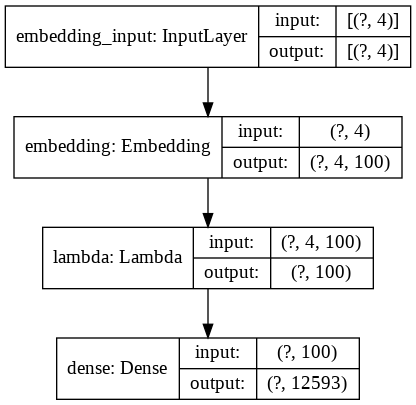

In [21]:
plot_model(model, to_file='tf-text-cbow.png', show_shapes=True)

### Train the CBOW model
We are now ready to train this model on our corpus
Using the data generator to feed in (context, target_word) pairs, we train the CBOW model for up to `10` epochs.

In [22]:
model.fit(train_ds, epochs=10, callbacks=[wandb_callback])

Train for 14133 steps
Epoch 1/10
14133/14133 [==============================] - 208s 15ms/step - loss: 5.1382
Epoch 2/10
14133/14133 [==============================] - 194s 14ms/step - loss: 5.1070
Epoch 3/10
14133/14133 [==============================] - 188s 13ms/step - loss: 4.9947
Epoch 4/10
14133/14133 [==============================] - 172s 12ms/step - loss: 4.8916
Epoch 5/10
14133/14133 [==============================] - 170s 12ms/step - loss: 4.8306
Epoch 6/10
14133/14133 [==============================] - 166s 12ms/step - loss: 4.7856
Epoch 7/10
14133/14133 [==============================] - 170s 12ms/step - loss: 4.7458
Epoch 8/10
14133/14133 [==============================] - 171s 12ms/step - loss: 4.7145
Epoch 9/10
14133/14133 [==============================] - 173s 12ms/step - loss: 4.6827
Epoch 10/10
14133/14133 [==============================] - 179s 13ms/step - loss: 4.6585


### Get the word2vec weights

Each word in the vocab has a dense embedding of size (1x100).

In [31]:
weights = model.get_weights()[0]
print(weights.shape)

(12593, 100)


### Contextual similarty

#### Compute pairwise distance matrix

We can levearage the embeddings that we just trained to find out some contextual similariry among words. For this, we need to do the following:

1. Build a pairwise distance matrix betweem all words in our vocabulary based on the embedding vectors.
2. Find the n-nearest neighbors of each word based on the shortest (euclidean) distance.

In [32]:
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

(12593, 12593)


#### View contextually similar words

We can clearly see that some of the closest words to the initial words make sense contextually (egypt, canaan).
This is a good sign as it we can get better embeddings if we train for more epochs.

In [0]:
target = ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']

indices = word2index.lookup(tf.constant(target))
top5_indices = distance_matrix[indices.numpy()].argsort()[:, 1:6]
top5 = index2word.lookup(tf.constant(top5_indices)).numpy().tolist()

In [49]:
pd.DataFrame(
  [[t]+c for c,t in zip(top5, target)],
  columns=["word", "top1", "top2", "top3", "top4", "top5"]
)

,word,top1,top2,top3,top4,top5
0,god,b'wherefore',b'being',b'things',b'evil',b'heart'
1,jesus,b'john',b'peter',b'simon',b'paul',b'named'
2,noah,b'nahor',b'milcah',b'arphaxad',b'shelah',b'terah'
3,egypt,b'canaan',b'edom',b'moab',b'gilead',b'bashan'
4,john,b'simon',b'peter',b'judas',b'philip',b'iscariot'
5,gospel,b'baptism',b'preaching',b'baptist',b'preach',b'gift'
6,moses,b'david',b'joseph',b'saul',b'esau',b'abraham'
7,famine,b'pestilence',b'stork',b'pots',b'amorite',b'bases'


Next, we will explore the skip-gram architecture which often gives better results than CBOW.